In [1]:
# import pyspark
# from pyspark.shell import sqlContext
# from pyspark.sql.functions import udf
# from pyspark.sql import functions
# from pyspark.sql import functions as F
# from pyspark.sql import Row
# from pyspark.sql.types import *
# from pyspark.sql.functions import broadcast

# from pyspark.sql import SparkSession
# from pyspark.sql import SQLContext
# from pyspark import SparkContext
# from pyspark.sql import Row
# from pyspark.sql import Window

import sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random
import copy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

import os, sys

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

import tensorflow as tf

from collections import deque

import keras

from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot


Using TensorFlow backend.


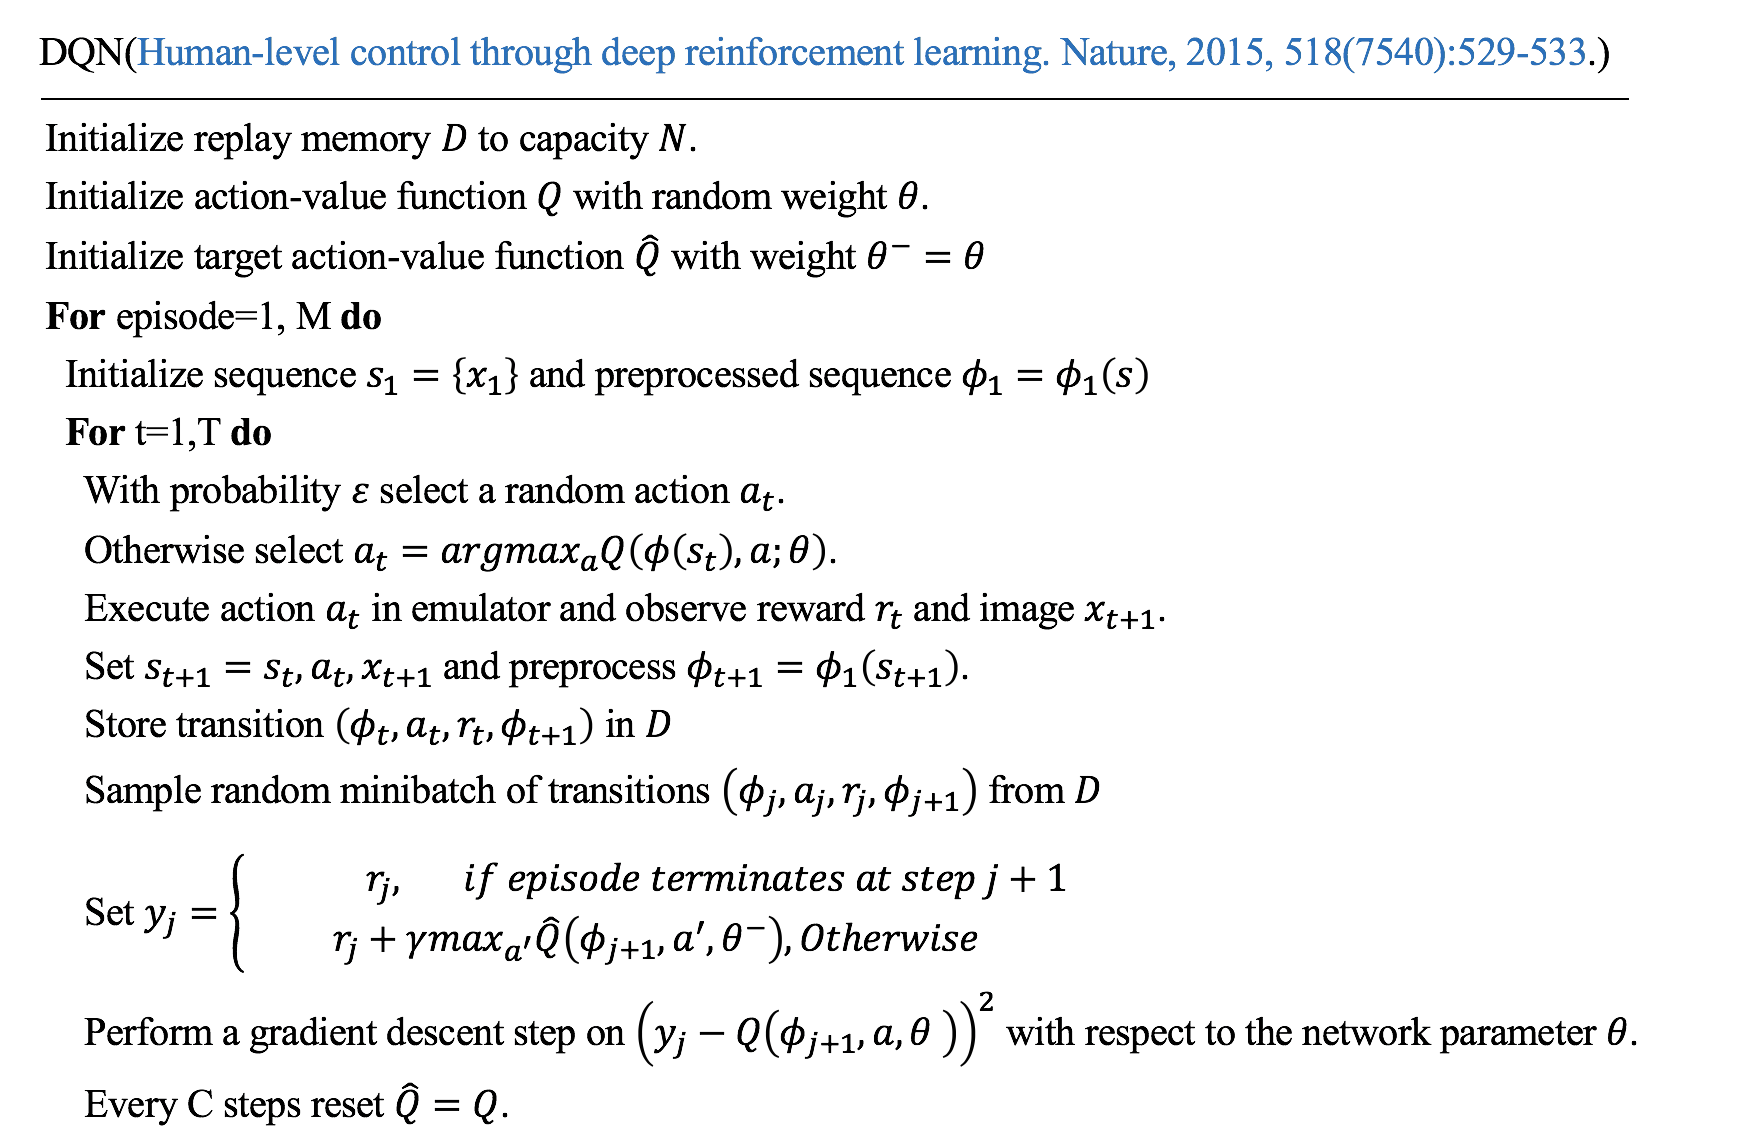

# 01 Q-learning Review
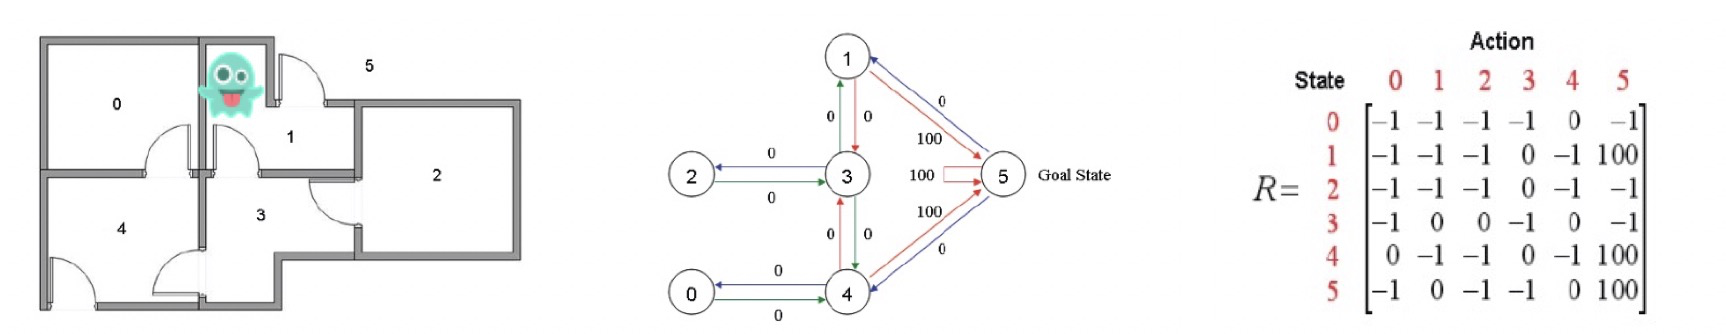

In [2]:
# 动作数。
ACTIONS = 6

# 探索次数。
episode = 100

# 目标状态，即：移动到 5 号房间。
target_state = 5

# γ，折损率，取值是 0 到 1 之间。
gamma = 0.8

# 经验矩阵。
q = np.zeros((6, 6))


def create_r():
    
    r = np.array([[-1, -1, -1, -1, 0, -1],
                  [-1, -1, -1, 0, -1, 100.0],
                  [-1, -1, -1, 0, -1, -1],
                  [-1, 0, 0, -1, 0, -1],
                  [0, -1, -1, 1, -1, 100],
                  [-1, 0, -1, -1, 0, 100],
                  ])
    return r


def get_next_action():
    
    next_action = np.random.randint(0, ACTIONS)

    return next_action


if __name__ == '__main__':
    
    r = create_r()

    print("R-table:")
    
    print(r)

    for index in range(episode):

        start_room = np.random.randint(0, 5)

        current_state = start_room

        while current_state != target_state:
            
            '''下一步action选择也比较粗糙'''
            
            current_action = get_next_action()

            current_action_point = r[current_state][current_action]

            if current_action_point < 0:
                
                q[current_state][current_action] = current_action_point
            else:
                next_state = current_action
 
                next_state_max_q = q[next_state].max()
    
                '''这里alpha的学习率设置为1'''
    
                q[current_state][current_action] = current_action_point + gamma * next_state_max_q

                current_state = next_state

    print("Q-table:")
    
    print(q)

    start_room = np.random.randint(0, 5)
    current_state = start_room

    step = 0

    while current_state != target_state:
        
        next_state = np.argmax(q[current_state])

        print("Agent starts from", current_state, "and moves to", next_state)

        current_state = next_state

        step += 1

    print("Agent starts from", start_room, "after", step, "steps to room 5")

R-table:
[[ -1.  -1.  -1.  -1.   0.  -1.]
 [ -1.  -1.  -1.   0.  -1. 100.]
 [ -1.  -1.  -1.   0.  -1.  -1.]
 [ -1.   0.   0.  -1.   0.  -1.]
 [  0.  -1.  -1.   1.  -1. 100.]
 [ -1.   0.  -1.  -1.   0. 100.]]
Q-table:
[[ -1.   -1.   -1.   -1.   80.   -1. ]
 [ -1.   -1.   -1.   64.   -1.  100. ]
 [ -1.   -1.   -1.   64.   -1.   -1. ]
 [ -1.   80.   51.2  -1.   80.   -1. ]
 [ 64.   -1.   -1.   65.   -1.  100. ]
 [  0.    0.    0.    0.    0.    0. ]]
Agent starts from 4 and moves to 5
Agent starts from 4 after 1 steps to room 5


# 02 Demo of Nerual Network
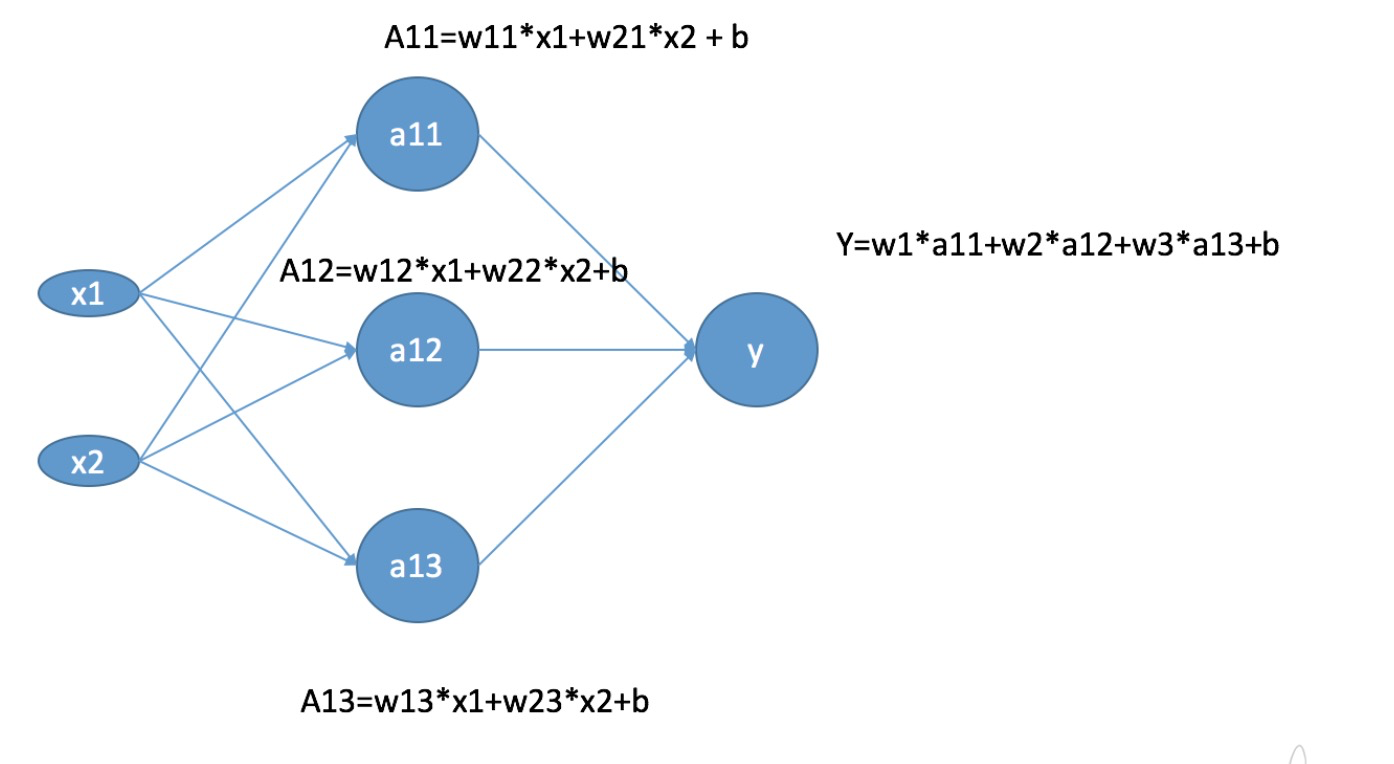

In [3]:
'''每次喂入神经网络的数据'''
BATCH_size=8

'''基于seed产生随机数'''
seed=23455
rng=np.random.RandomState(seed)

X=rng.rand(32,2)
'''从X这个32行两列的矩阵中取出一行，判断如果和小于1给Y赋值为1'''
'''如果不小于1，给Y赋值为0,作为输入数据集的标签'''
Y=[[int(x0+x1<1)]for (x0,x1) in X]

'''不知道传入多少组数据，用place holder占位'''
x=tf.placeholder(tf.float32,shape=(None,2))
y_=tf.placeholder(tf.float32,shape=(None,1))

'''定义隐藏层参数'''
w1=tf.Variable(tf.random_normal([2,3],stddev=1,seed=1))
w2=tf.Variable(tf.random_normal([3,1],stddev=1,seed=1))


a=tf.matmul(x,w1)
y=tf.matmul(a,w2)

'''定义损失函数及反向传播方法'''
loss=tf.reduce_mean(tf.square(y-y_))
train_step=tf.train.GradientDescentOptimizer(0.001).minimize(loss)


'''生成会话，训练steps轮'''
with tf.Session() as sess:
    init_op=tf.global_variables_initializer()
    sess.run(init_op)

    '''训练模型'''
    steps=3001
    for i in range(steps):
        start=(i*BATCH_size)%32
        end=start+BATCH_size
        sess.run(train_step,feed_dict={x:X[start:end],y_:Y[start:end]})
        if i%500==0:
            total_loss=sess.run(loss,feed_dict={x:X,y_:Y})
            print("after %d training steps,loss on all data is %g"%(i,total_loss))

Instructions for updating:
Colocations handled automatically by placer.
after 0 training steps,loss on all data is 5.13118
after 500 training steps,loss on all data is 0.429111
after 1000 training steps,loss on all data is 0.409789
after 1500 training steps,loss on all data is 0.399923
after 2000 training steps,loss on all data is 0.394146
after 2500 training steps,loss on all data is 0.390597
after 3000 training steps,loss on all data is 0.388336


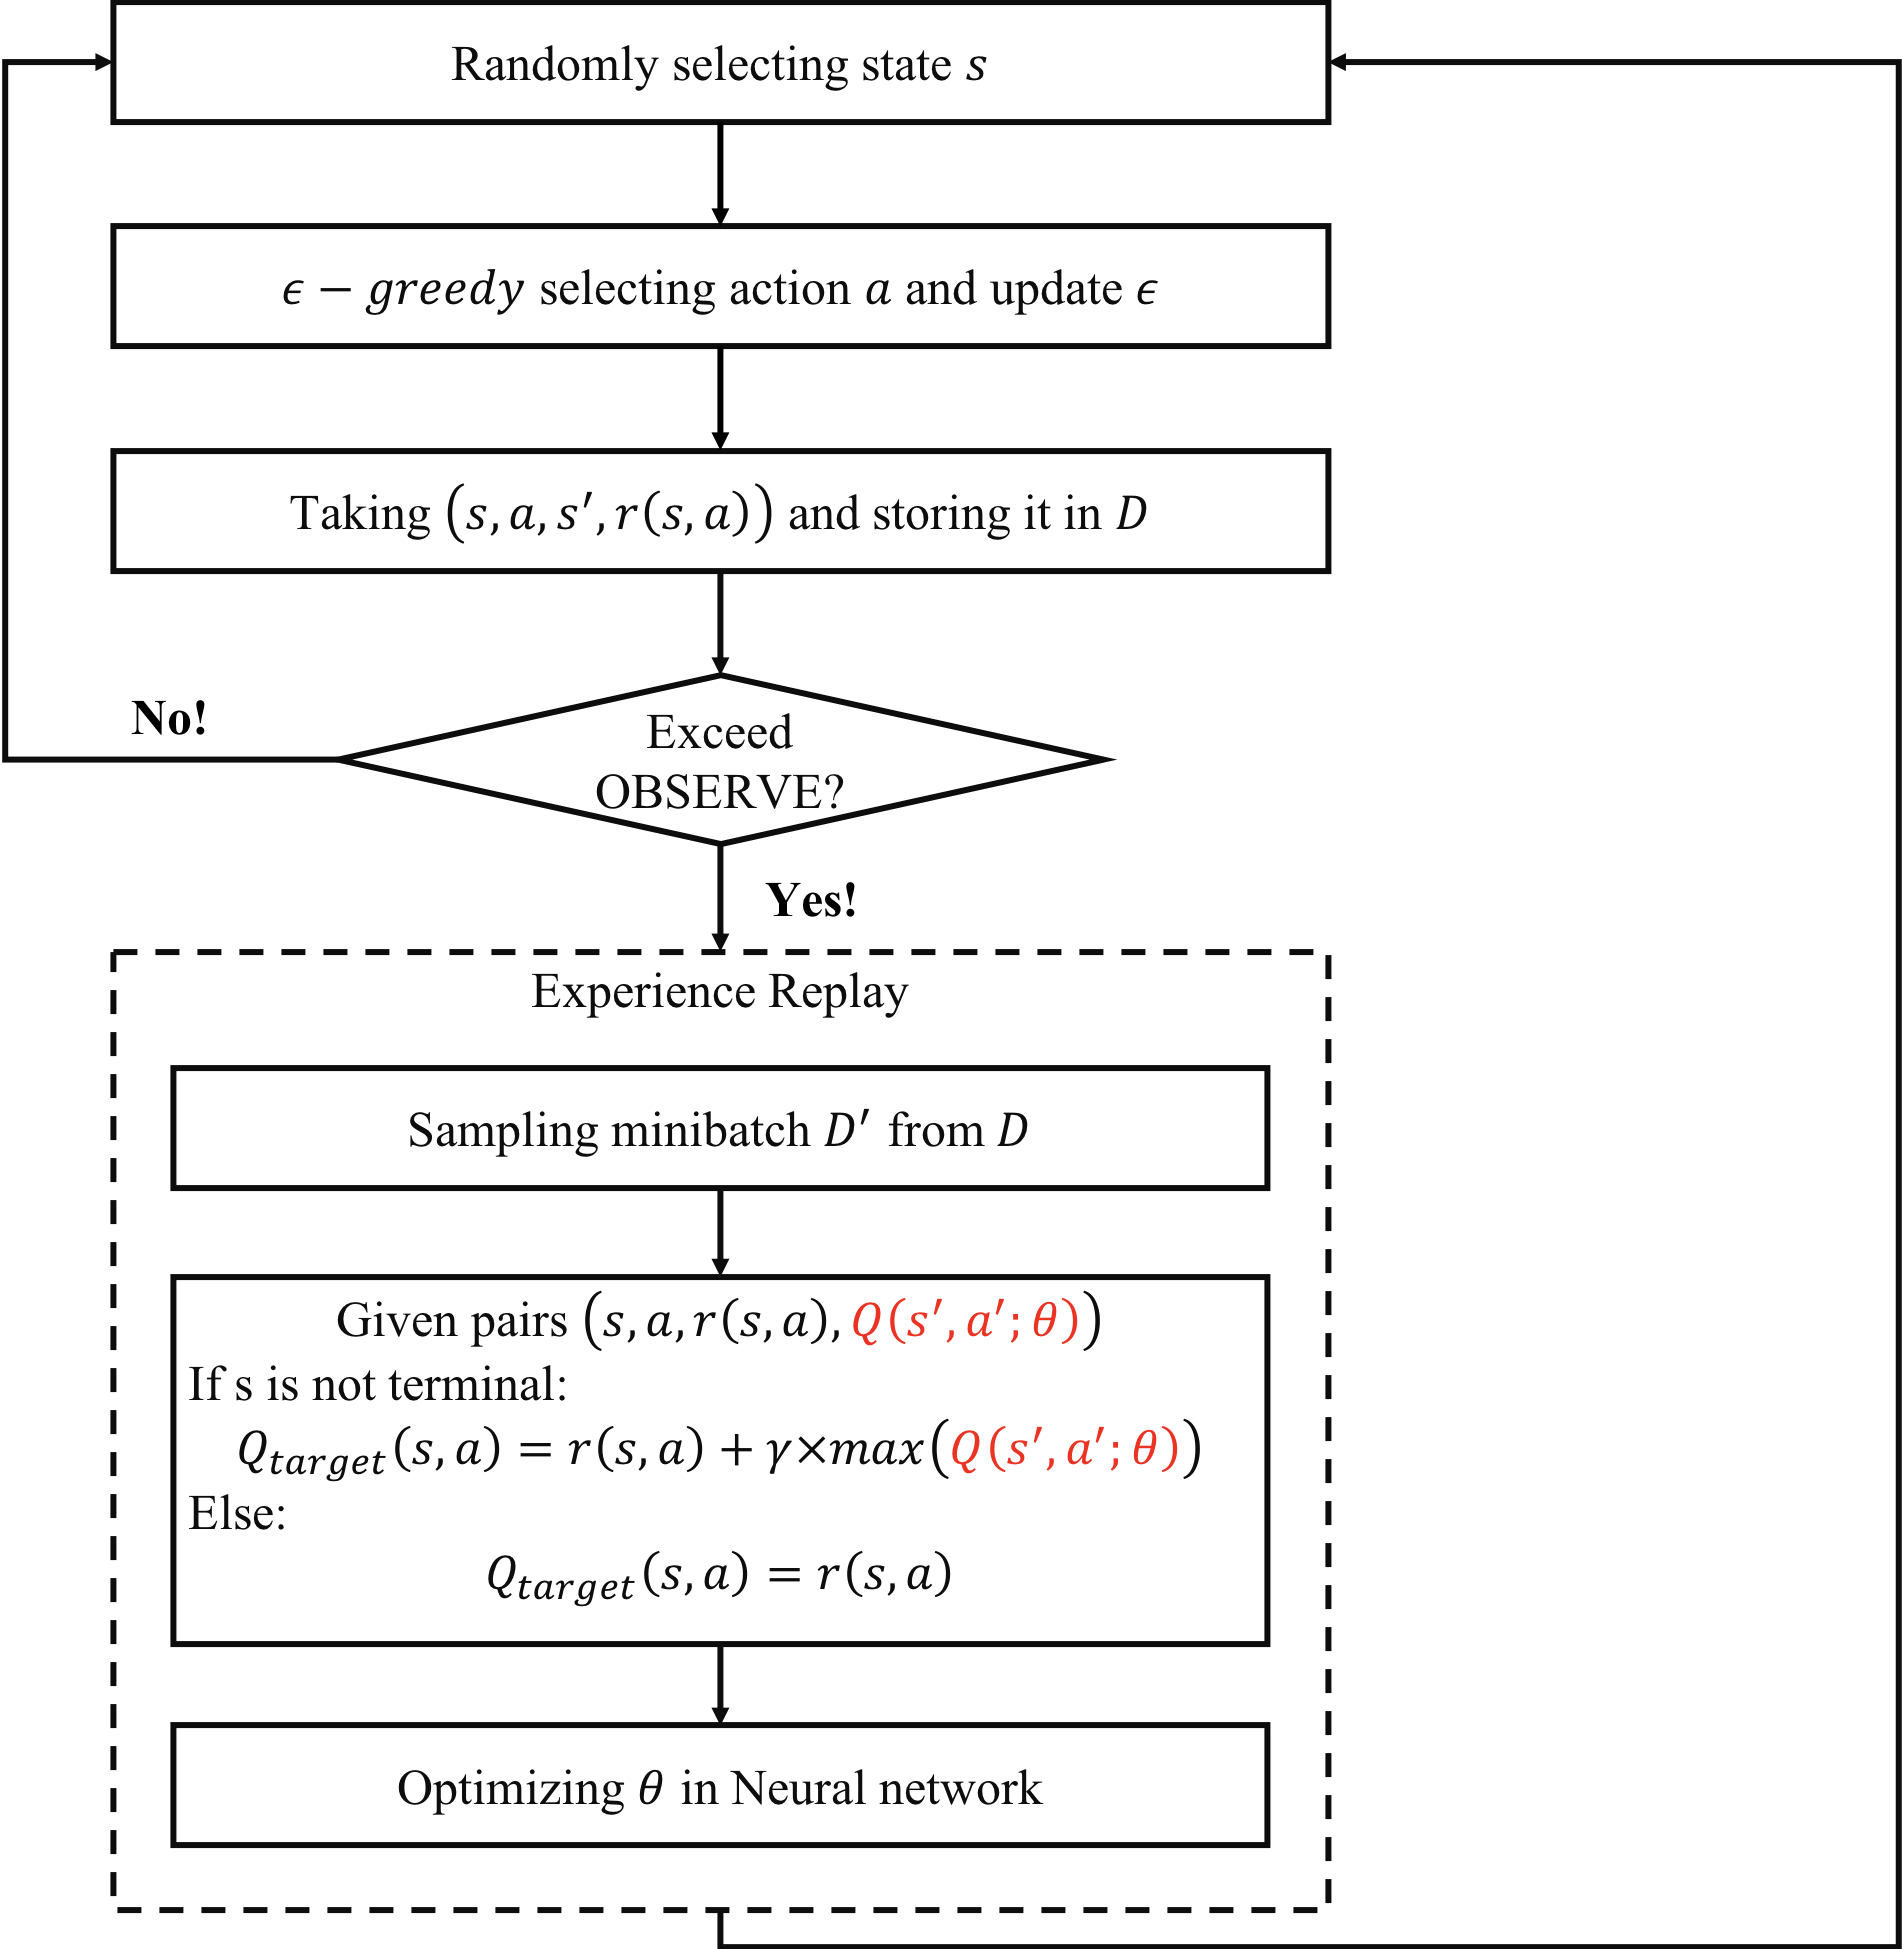

# 03 Deep Q learning

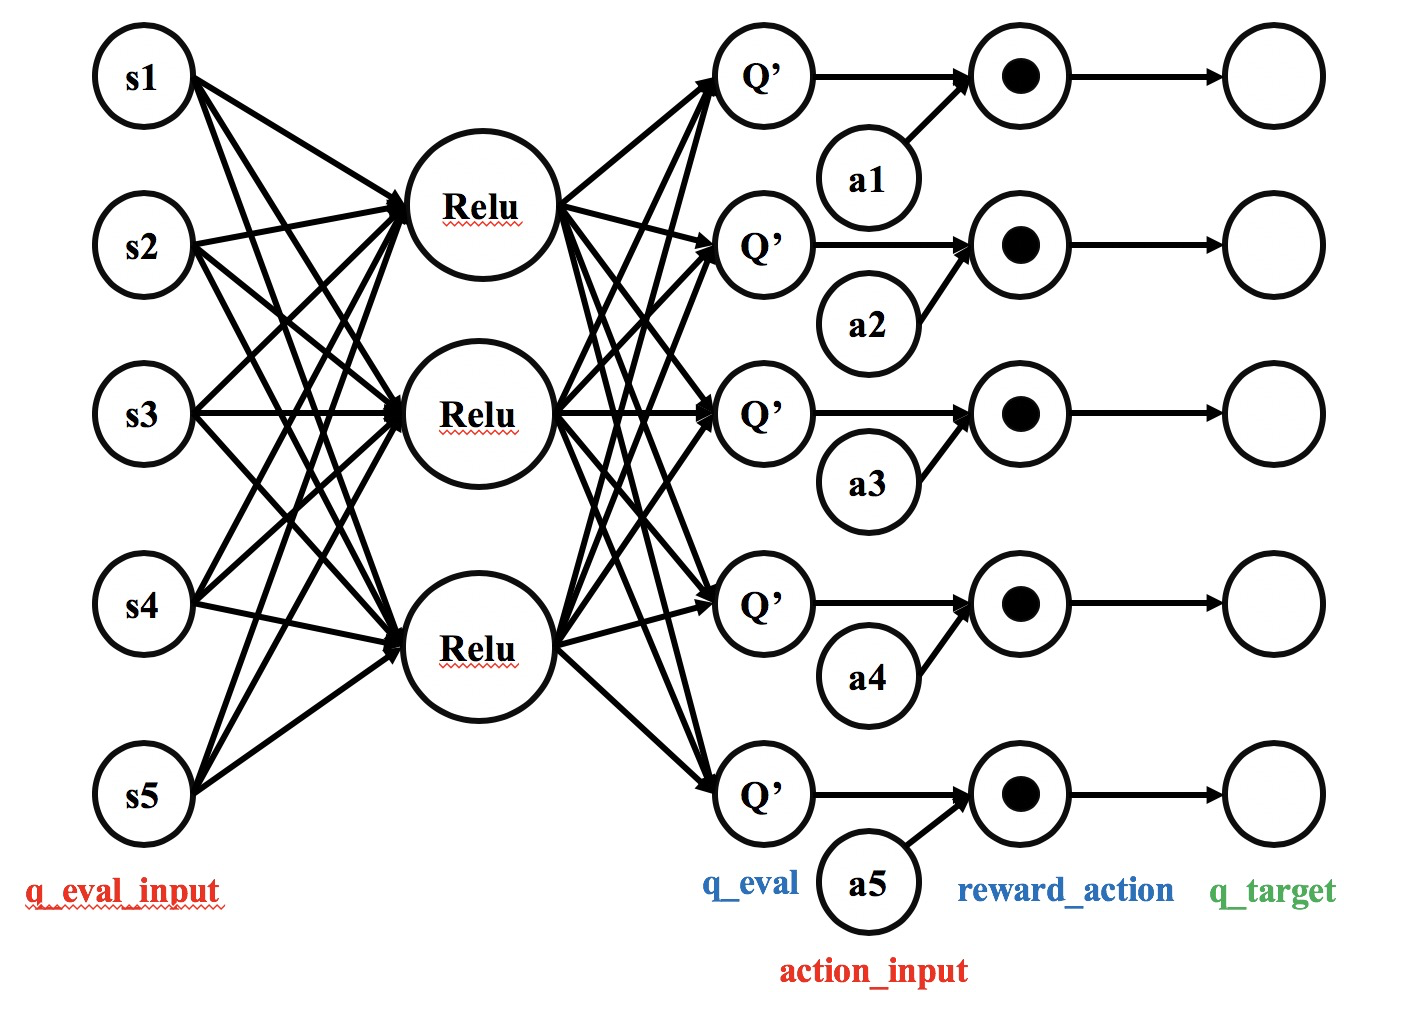

In [4]:
class DeepQNetwork:
    
    '''初始化DATA'''

    r = np.array([[-1, -1, -1, -1, 0, -1],
                  [-1, -1, -1, 0, -1, 100.0],
                  [-1, -1, -1, 0, -1, -1],
                  [-1, 0, 0, -1, 0, -1],
                  [0, -1, -1, 1, -1, 100],
                  [-1, 0, -1, -1, 0, 100],
                  ])

    '''执行步数'''
    step_index = 0

    '''状态数'''
    state_num = 6

    '''动作数'''
    action_num = 6

    '''训练之前观察多少步'''
    OBSERVE = 1000.

    '''选取的小批量训练样本数'''
    BATCH = 20

    '''epsilon 的最小值，当 epsilon 小于该值时，将不在随机选择行为'''
    FINAL_EPSILON = 0.0001

    '''epsilon 的初始值，epsilon 逐渐减小'''
    INITIAL_EPSILON = 0.1

    '''epsilon 衰减的总步数'''
    EXPLORE = 3000000.

    '''探索模式计数'''
    epsilon = 0

    '''训练步数统计'''
    learn_step_counter = 0

    '''学习率'''
    learning_rate = 0.001

    '''经验折损率'''
    gamma = 0.9

    '''记忆上限'''
    memory_size = 5000

    '''当前记忆数'''
    memory_counter = 0

    '''保存观察到的执行过的行动的存储器，曾经经历过的记忆'''
    replay_memory_store = deque()

    '''生成一个状态矩阵，每一行代表一个状态'''
    state_list = None

    '''生成一个动作矩阵'''
    action_list = None

    '''q_eval 网络'''
    
    q_eval_input = None
    action_input = None
    q_target = None
    q_eval = None
    predict = None
    loss = None
    train_op = None
    cost_his = None
    reward_action = None

    '''tensorflow 会话'''
    session = None
    
    def __init__(self, learning_rate=0.001, gamma=0.9, memory_size=5000):
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.memory_size = memory_size

        '''初始化成一个 6 X 6 的状态矩阵'''
        self.state_list = np.identity(self.state_num)

        '''初始化成一个 6 X 6 的动作矩阵'''
        self.action_list = np.identity(self.action_num)

        '''创建神经网络'''
        self.create_network()

        '''初始化 tensorflow 会话'''
        self.session = tf.InteractiveSession()

        '''初始化 tensorflow 参数'''
        self.session.run(tf.initialize_all_variables())

        '''记录所有 loss 变化'''
        self.cost_his = []

    def create_network(self):
        
        """
        创建神经网络。
        :return:
        """
        
        '''初始化输入输出层'''
        
        '''第一层输入层，输入为state'''
        self.q_eval_input = tf.placeholder(shape=[None, self.state_num], dtype=tf.float32)
        
        '''第二层输入层，输入为action'''
        self.action_input = tf.placeholder(shape=[None, self.action_num], dtype=tf.float32)
        
        '''输出层'''
        self.q_target = tf.placeholder(shape=[None], dtype=tf.float32)

        neuro_layer_1 = 3
        
        '''第一层神经网络'''
        w1 = tf.Variable(tf.random_normal([self.state_num, neuro_layer_1]))
        b1 = tf.Variable(tf.zeros([1, neuro_layer_1]) + 0.1)
        l1 = tf.nn.relu(tf.matmul(self.q_eval_input, w1) + b1)
        
        '''第二层神经网络'''

        w2 = tf.Variable(tf.random_normal([neuro_layer_1, self.action_num]))
        b2 = tf.Variable(tf.zeros([1, self.action_num]) + 0.1)
        self.q_eval = tf.matmul(l1, w2) + b2

        
        '''第三层神经网络，输出当前得分'''
        self.reward_action = tf.reduce_sum(tf.multiply(self.q_eval, self.action_input), reduction_indices=1)
        
        '''定义当前的loss'''
        self.loss = tf.reduce_mean(tf.square((self.q_target - self.reward_action)))
        
        '''最优化迭代'''
        self.train_op = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)

        self.predict = tf.argmax(self.q_eval, 1)

    def select_action(self, state_index):
        
        """
        根据策略选择动作。
        :param state_index: 当前状态。
        :return:
        """
        
        '''需要注意到在这个函数之中，动作是严格按照epsilon-greedy的原则来选择'''
        
        '''定位当前的状态'''
        current_state = self.state_list[state_index:state_index + 1]
        
        '''当生成的随机数小于epsilon，此时随机选择一个action'''
        
        '''当生成的随机数大于epsilon，此时选择一个基于神经网络预测的Q最大action（这里与神经网络进行了交互）'''
        
        if np.random.uniform() < self.epsilon:
            current_action_index = np.random.randint(0, self.action_num)
        else:
            actions_value = self.session.run(self.q_eval, feed_dict={self.q_eval_input: current_state})
            action = np.argmax(actions_value)
            current_action_index = action
            
        '''更新epsilon'''

        if self.step_index > self.OBSERVE and self.epsilon > self.FINAL_EPSILON:
            
            self.epsilon -= (self.INITIAL_EPSILON - self.FINAL_EPSILON) / self.EXPLORE

        return current_action_index

    def save_store(self, current_state_index, current_action_index, current_reward, next_state_index, done):
        
        """
        保存记忆。
        :param current_state_index: 当前状态 index。
        :param current_action_index: 动作 index。
        :param current_reward: 奖励。
        :param next_state_index: 下一个状态 index。
        :param done: 是否结束。
        :return:
        """
        '''定位当前的状态'''
        current_state = self.state_list[current_state_index:current_state_index + 1]
        '''定位当前的动作'''
        current_action = self.action_list[current_action_index:current_action_index + 1]
        '''定位转移后的状态，综上所述，记忆了(s,a,s')的pair'''
        next_state = self.state_list[next_state_index:next_state_index + 1]
        
        
        '''更新记忆的数据库'''
        
        self.replay_memory_store.append((
            current_state,
            current_action,
            current_reward,
            next_state,
            done))

        '''如果超过记忆的容量，则将最久远的记忆移除'''
        
        if len(self.replay_memory_store) > self.memory_size:
            self.replay_memory_store.popleft()

        self.memory_counter += 1

    def step(self, state, action):
        """
        执行动作。
        :param state: 当前状态。
        :param action: 执行的动作。
        :return:
        """
        
        '''输入state,action 返回next_state,reward,done'''
        reward = self.r[state][action]

        next_state = action

        done = False

        if action == 5:
            
            done = True

        return next_state, reward, done

    def experience_replay(self):
        
        """
        记忆回放。
        :return:
        """
        '''在DQN之中最重要的的步骤'''
        
        '''根据设置的BATCH在之前的replay_memory_store之中选取训练样本'''
        batch = self.BATCH if self.memory_counter > self.BATCH else self.memory_counter
        
        '''在replay_memory_store之中随机抽样'''
        minibatch = random.sample(self.replay_memory_store, batch)

        batch_state = None
        batch_action = None
        batch_reward = None
        batch_next_state = None
        batch_done = None
        
        '''replay_memory_store=0:current_state,1:current_action,2:current_reward,3:next_state,4:done'''
        for index in range(len(minibatch)):
            if batch_state is None:
                batch_state = minibatch[index][0]
            elif batch_state is not None:
                batch_state = np.vstack((batch_state, minibatch[index][0]))

            if batch_action is None:
                batch_action = minibatch[index][1]
            elif batch_action is not None:
                batch_action = np.vstack((batch_action, minibatch[index][1]))

            if batch_reward is None:
                batch_reward = minibatch[index][2]
            elif batch_reward is not None:
                batch_reward = np.vstack((batch_reward, minibatch[index][2]))

            if batch_next_state is None:
                batch_next_state = minibatch[index][3]
            elif batch_next_state is not None:
                batch_next_state = np.vstack((batch_next_state, minibatch[index][3]))

            if batch_done is None:
                batch_done = minibatch[index][4]
            elif batch_done is not None:
                batch_done = np.vstack((batch_done, minibatch[index][4]))

        '''预测下一个状态batch_next_state的Q值'''
        
        
        
        q_next = self.session.run([self.q_eval], feed_dict={self.q_eval_input: batch_next_state})
        
        
        '''q_next 表示这批样本中所有的 next_state 状态的 Q 值表的集合'''
        
        """
        现在，已经拿到了

        Agent 当时的状态（state），

        当时的动作（action），

        当时的状态（state）下执行动作（action）得到的奖励R(state, action)，

        当时的状态（state）下执行动作（action）后的状态（next_state）下所有可执行的动作的 Q 值表（q_next）
        
        """

        q_target = []
        for i in range(len(minibatch)):
            
            '''当前即时得分'''
            current_reward = batch_reward[i][0]

            '''更新Q值'''
            '''Q(state, action) = R(state, action) + Gamma * Max{q_next}'''
            q_value = current_reward + self.gamma * np.max(q_next[0][i])

            '''当得分小于 -1 时，表示走了不可走的位置'''
            
            '''更新q_target'''
            
            if current_reward <= -1:
                q_target.append(current_reward)
            else:
                q_target.append(q_value)
                
        '''将这批样本的当前状态的集合，动作的集合与 q_target 传入神经网络并进行训练'''

        _, cost, reward = self.session.run([self.train_op, self.loss, self.reward_action],
                                           feed_dict={self.q_eval_input: batch_state,
                                                      self.action_input: batch_action,
                                                      self.q_target: q_target})
        
        self.cost_his.append(cost)

        self.learn_step_counter += 1

    def train(self):
        """
        训练。
        :return:
        """
        
        '''初始化当前参数'''
        
        '''随机选取state'''
        current_state = np.random.randint(0, self.action_num - 1)
        
        '''初始化设定epsilon'''
        self.epsilon = self.INITIAL_EPSILON

        while True:
            
            '''依据Eplison选取动作'''
            action = self.select_action(current_state)

            '''在当前current_state, action输出next_state, reward, done'''
            next_state, reward, done = self.step(current_state, action)

            '''保存当前拿出来的eplison对'''
            self.save_store(current_state, action, reward, next_state, done)

            '''迭代次数超过OBSERVE，进行experience_replay'''
            
            if self.step_index > self.OBSERVE:
                
                self.experience_replay()
                
            '''迭代次数超过experience_replay'''

            if self.step_index > 10000:
                
                break

            if done:
                
                current_state = np.random.randint(0, self.action_num - 1)
                
            else:
                
                current_state = next_state

            self.step_index += 1

# 04 Result

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


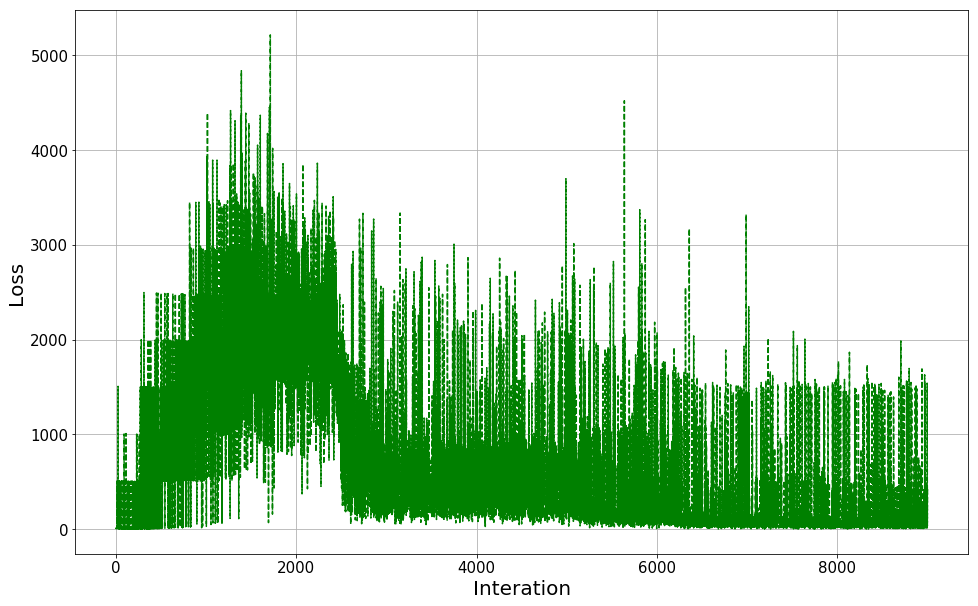

In [5]:
q_network = DeepQNetwork()
q_network.train()
figsize = 16,10
figure,ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
font = {'weight' : 'normal','size': 20}

plt.plot(range(len(q_network.cost_his)),q_network.cost_his,'g--')
plt.xlabel('Interation',font)
plt.ylabel('Loss',font)
plt.grid()
plt.show()